## Predicting the price and the cut of the diamonds
Data source: https://www.kaggle.com/datasets/shivam2503/diamonds

## Imports
Following imports and addtional installations are needed:

In [69]:
#Additional installations
!pip install pyod

In [70]:
#Importing the necessary libraries for the data mining process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyod.models.knn import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

In [71]:
#Importing the dataset
datapath = "data/diamonds.csv"
raw_df = pd.read_csv(datapath, index_col = 0)

## Data Understanding

Explanation of the dataset columns:

carat: Carat weight of the diamond

cut: Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very 
Good, Premium, Ideal

color: Color of the diamond, with D being the best and J the worst
clarity = How obvious inclusions are within the diamond: (I1 (worst), SI2, SI1, VS2, VS1, VVS2, 
VVS1, IF (best))
    
depth depth %: The height of a diamond, measured from the culet to the table, divided by 
its average girdle diameter

table table%: The width of the diamond's table expressed as a percentage of its average 
diameter

price: the price of the diamond in US dollars

x: length mm

y: width mm

z: depth m

In [72]:
#Checking the shape of the dataset
raw_df.shape

(53940, 10)

In [73]:
#Checking descriptive statistics for the numerical features
raw_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [74]:
#Checking datatypes and if the total of non-null values match the number of rows of the dataset
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


<AxesSubplot:title={'center':'Diamond price distribution'}, ylabel='Frequency'>

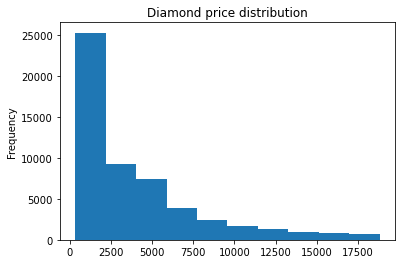

In [75]:
#Checking the price distribution
raw_df.price.plot.hist(title="Diamond price distribution")

<AxesSubplot:title={'center':'Cut frequency'}>

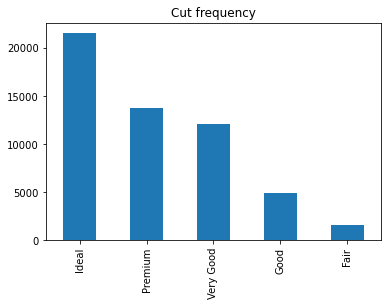

In [76]:
#Checking the cut frequency
raw_df['cut'].value_counts().plot.bar(title="Cut frequency")

In [77]:
#Checking the linear correlation between the numerical variables
raw_df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


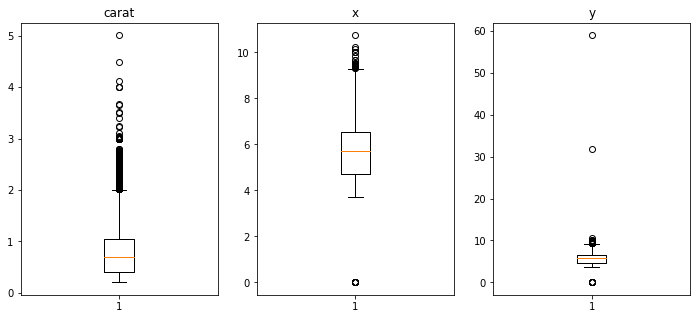

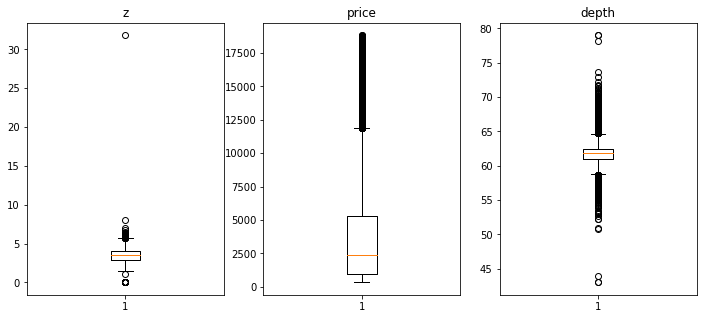

Text(0.5, 1.0, 'table')

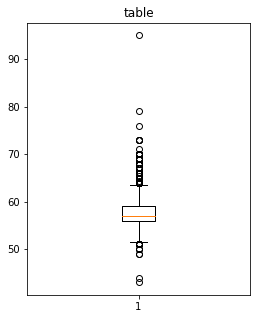

In [78]:
#checking the percentiles and existence of univariate outliers
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].boxplot(raw_df['carat'])
ax[0].set_title('carat')
ax[1].boxplot(raw_df['x'])
ax[1].set_title('x')
ax[2].boxplot(raw_df['y'])
ax[2].set_title('y')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].boxplot(raw_df['z'])
ax[0].set_title('z')
ax[1].boxplot(raw_df['price'])
ax[1].set_title('price')
ax[2].boxplot(raw_df['depth'])
ax[2].set_title('depth')
plt.show()

fig, ax = plt.subplots(figsize=(4,5))
ax.boxplot(raw_df['table'])
ax.set_title('table')


## Data preparation

### The regression dataset

In [79]:
#Creating the dataset for the regression problem
df_reg = raw_df.copy()

In [80]:
#Transforming categorical data in numerical data in the regression dataset
df_reg = pd.get_dummies(df_reg)

In [81]:
#Dropping the rows with dimensions equal to zero (because that is not possible)
df_reg = df_reg.drop(df_reg[df_reg['x'] == 0].index)
df_reg = df_reg.drop(df_reg[df_reg['y'] == 0].index)
df_reg = df_reg.drop(df_reg[df_reg['z'] == 0].index)

In [82]:
#Creating and fitting an outlier detector
detector = KNN()
detector.fit(df_reg)
outliers_reg = detector.labels_

In [83]:
#Creating a column in the dataset to identify the outliers
df_reg['outliers'] = outliers_reg

#Creating an array with outlier indexes
index_outliers = df_reg[df_reg['outliers']==1].index.values

#Removing the outliers
for i in index_outliers:
    df_reg = df_reg.drop(index=i)

#Removing the outliers column
df_reg = df_reg.drop('outliers', axis=1)

### The classification dataset

In [84]:
#Creating the dataset for the classification
df_clf = raw_df.copy()
df_clf = df_clf.drop(["carat","color","price","clarity"], axis=1)

In [85]:
#Transforming the cut in numerical data
df_clf = pd.get_dummies(df_clf)

In [86]:
#Dropping the rows with dimensions equal to zero (because that is not possible)
df_clf = df_clf.drop(df_clf[df_clf['x'] == 0].index)
df_clf = df_clf.drop(df_clf[df_clf['y'] == 0].index)
df_clf = df_clf.drop(df_clf[df_clf['z'] == 0].index)

In [87]:
#Fitting the outlier detector in the classification dataset
detector.fit(df_clf)
outliers_clf = detector.labels_

In [88]:
#Creating a column in the dataset to identify the outliers
df_clf['outliers'] = outliers_clf

##Creating an array with outlier indexes
index_outliers2 = df_clf[df_clf['outliers']==1].index.values

#Returning the text data to our labels
df_clf['cut'] = raw_df['cut']
df_clf = df_clf.drop(['cut_Fair','cut_Good','cut_Ideal','cut_Premium','cut_Very Good'], axis=1)

#Removing the outliers
for i in index_outliers2:
    df_clf = df_clf.drop(index=i)
    
#Removing the outliers columns
df_clf = df_clf.drop('outliers', axis=1)

In [89]:
#Standardizing the classification dataset
df_clf[["depth", "table","y","x","z",]] = StandardScaler().fit_transform(df_clf[["depth", "table","y","x","z"]])

## Modeling

### The regression model (predicting the price)

In [90]:
#Defining our independent and dependent variables for the regression problem
independent_reg = df_reg.drop("price", axis=1)
dependent_reg = df_reg['price']

In [91]:
#Spliting the data in training and test set for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(independent_reg, dependent_reg, test_size=0.2, 
                                                                    random_state=42)

In [92]:
#Instanciating and fitting the regression model
Model_reg = RandomForestRegressor(random_state=42, bootstrap= True, max_depth=50, max_features=10, min_samples_leaf= 1, 
                                  min_samples_split=5, n_estimators=100)
Model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = Model_reg.predict(X_test_reg)

### The classification model (predicting the cut)

In [93]:
#Defining our independent and dependent variables for the classification problem
independent_clf = df_clf.drop("cut", axis=1)
dependent_clf = df_clf['cut']

In [94]:
#Splitting the data in training and test set for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(independent_clf, dependent_clf, test_size=0.2, 
                                                                    random_state=42)

In [95]:
#Instanciating and fitting the classification model
Model_clf = svm.SVC(random_state=42, C= 1000, gamma= 0.1, kernel='rbf', shrinking=False, tol= 1)
Model_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = Model_clf.predict(X_test_clf)

## Evaluation

### Evaluating the regression model

In [96]:
# Checking the performance of the regression model
mse = mean_squared_error(y_test_reg, y_pred_reg)
print("MSE : "+ str(mse))
rmse= np.sqrt(mse)
print("RMSE: "+ str(rmse))
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("MAE : "+ str(mae))
r2 = r2_score(y_test_reg, y_pred_reg)
print("R2  : "+ str(r2))

MSE : 175260.78234145412
RMSE: 418.64159174818514
MAE : 209.89047371732917
R2  : 0.9793702047173429


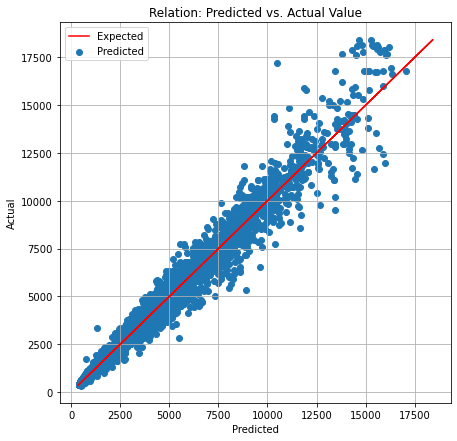

In [97]:
# Plotting the graph of the predicted  x actual actual values of the test set 
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(y_test_reg, y_test_reg, label="Expected", color = "red")
ax.scatter(y_pred_reg, y_test_reg, label = "Predicted")

ax.set(xlabel='Predicted', ylabel='Actual',
       title='Relation: Predicted vs. Actual Value')

ax.grid()
ax.legend()

plt.show()

### Evaluating the classification model

In [98]:
#Checking the performance of the classification model
print(classification_report(y_test_clf, y_pred_clf))

              precision    recall  f1-score   support

        Fair       0.99      0.99      0.99       104
        Good       0.83      0.69      0.75       649
       Ideal       0.84      0.95      0.89      4244
     Premium       0.87      0.78      0.82      2509
   Very Good       0.68      0.63      0.66      2200

    accuracy                           0.82      9706
   macro avg       0.84      0.81      0.82      9706
weighted avg       0.81      0.82      0.81      9706



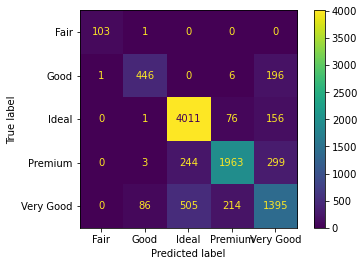

In [99]:
#Ploting a confusion matrix for the test set of the classification model
ConfusionMatrixDisplay.from_estimator(Model_clf, X_test_clf, y_test_clf)

# plt.grid(visible=None)
plt.show()